#  로지스틱 회귀 최종 레포트

- 목표 : '우울증' 예측 로지스틱 회귀 모델 만들기

- 데이터 셋 : Depression 조사 데이터(Kaggle DataSet)

In [3]:
import pandas as pd
import numpy as np
df=pd.read_csv('C:/portfolio/code/week4/day7/depression_data.csv')

## 데이터 전처리

### 1. '이름' 열 삭제

In [4]:
df=df.drop(columns=['Name'])

### 2. 범주형 변수의 수치화

- 이진형 변수의 수치화 : `map()` 사용

In [5]:
df['History of Mental Illness'] = df['History of Mental Illness'].map({'Yes': 1, 'No': 0})

df['History of Substance Abuse']=df['History of Substance Abuse'].map({'Yes' : 1, 'No' : 0})

df['Family History of Depression']=df['Family History of Depression'].map({'Yes' : 1, 'No' : 0})

df['Chronic Medical Conditions']=df['Chronic Medical Conditions'].map({'Yes' : 1, 'No' : 0})

df['Employment Status']=df['Employment Status'].map({'Employed' : 1, 'Unemployed' : 0})

- 다중 변수의 수치화 : `pd.get_dummies()` 사용(One-Hot Encoding)

In [6]:
multi_cols = [
    'Marital Status',
    'Education Level',
    'Smoking Status',
    'Physical Activity Level',
    'Alcohol Consumption',
    'Dietary Habits',
    'Sleep Patterns'
]
df=pd.get_dummies(df, columns=multi_cols, drop_first=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413768 entries, 0 to 413767
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Age                                413768 non-null  int64  
 1   Number of Children                 413768 non-null  int64  
 2   Employment Status                  413768 non-null  int64  
 3   Income                             413768 non-null  float64
 4   History of Mental Illness          413768 non-null  int64  
 5   History of Substance Abuse         413768 non-null  int64  
 6   Family History of Depression       413768 non-null  int64  
 7   Chronic Medical Conditions         413768 non-null  int64  
 8   Marital Status_Married             413768 non-null  bool   
 9   Marital Status_Single              413768 non-null  bool   
 10  Marital Status_Widowed             413768 non-null  bool   
 11  Education Level_Bachelor's Degree  4137

In [6]:
df.head()

,Age,Number of Children,Employment Status,Income,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions,Marital Status_Married,Marital Status_Single,...,Smoking Status_Former,Smoking Status_Non-smoker,Physical Activity Level_Moderate,Physical Activity Level_Sedentary,Alcohol Consumption_Low,Alcohol Consumption_Moderate,Dietary Habits_Moderate,Dietary Habits_Unhealthy,Sleep Patterns_Good,Sleep Patterns_Poor
0,31,2,0,26265.67,1,0,1,1,True,False,...,False,True,False,False,False,True,True,False,False,False
1,55,1,1,42710.36,1,0,0,1,True,False,...,False,True,False,True,False,False,False,True,False,False
2,78,1,1,125332.79,0,0,1,0,False,False,...,False,True,False,True,True,False,False,True,True,False
3,58,3,0,9992.78,0,0,0,0,False,False,...,False,True,True,False,False,True,True,False,False,True
4,18,0,0,8595.08,1,0,1,1,False,True,...,False,True,False,True,True,False,True,False,False,False


### 3. 'Depression' 열 생성

- History of Mental Illness 또는 Family History of Depression 가 yes이면 우울증 가능성 있음(1), 둘 다 없으면 0

In [7]:
df['Depression']=np.where(
    (df['History of Mental Illness']==1) | (df['Family History of Depression']==1), 1,0
)

In [8]:
df['Depression'].value_counts()

Depression
0    210934
1    202834
Name: count, dtype: int64

## 간단한 EDA

- 우울증에 주요하게 영향을 미치는 요인을 탐색하기 위해 상관계수 분석을 시행

In [9]:
df.corr()['Depression'].sort_values(ascending=False)

Depression                           1.000000
History of Mental Illness            0.674114
Family History of Depression         0.618423
Marital Status_Widowed               0.148503
Age                                  0.082048
Number of Children                   0.051460
Physical Activity Level_Sedentary    0.023240
Education Level_High School          0.015603
Smoking Status_Non-smoker            0.015547
Sleep Patterns_Poor                  0.014420
Dietary Habits_Unhealthy             0.013310
Dietary Habits_Moderate              0.004532
Physical Activity Level_Moderate     0.003564
Chronic Medical Conditions           0.002847
Smoking Status_Former                0.001907
Education Level_PhD                 -0.001609
History of Substance Abuse          -0.001633
Alcohol Consumption_Low             -0.004205
Alcohol Consumption_Moderate        -0.006294
Education Level_Master's Degree     -0.011115
Sleep Patterns_Good                 -0.020633
Education Level_Bachelor's Degree 

- 대부분의 변수가 '우울증'과 상관계수가 매우 낮게 나타난다. 모델의 성능이 약하게 나올 가능성이 높다가 예측 가능하다.

## 모델 학습

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score

### 1. 변수 설정

In [9]:
X=df.drop(columns=['Depression',
                   'History of Mental Illness',
                   'Family History of Depression'])
y=df['Depression']

### 2. 수치형 변수 표준화 (StandardScaler)

In [10]:
num_cols=['Age', 'Income', 'Number of Children']
scaler=StandardScaler()
X[num_cols]=scaler.fit_transform(X[num_cols])

### 3. train세트, test세트 분할

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

### 4. 모델 학습

In [12]:
model=LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


### 5. 예측값 생성

In [13]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[: ,1]

### 6. 모델 성능 측정

1. 오차행렬, 정밀도, 재현율, f1-score 출력

In [23]:
def model_evaluate(df):
    print("🔹 confusion matrix")
    print(confusion_matrix(y_test, y_pred))

    print("\n🔹 classification report")
    print(classification_report(y_test, y_pred))

    print("\n🔹 ROC AUC score")
    print(roc_auc_score(y_test, y_proba))

    print('\n 🔹정밀도 : ',precision_score(y_test, y_pred))

    print('\n 🔹재현율 :', recall_score(y_test, y_pred))

    print('\n 🔹f1 score :', f1_score(y_test, y_pred))
model_evaluate(df)

🔹 confusion matrix
[[28279 13787]
 [21402 19286]]

🔹 classification report
              precision    recall  f1-score   support

           0       0.57      0.67      0.62     42066
           1       0.58      0.47      0.52     40688

    accuracy                           0.57     82754
   macro avg       0.58      0.57      0.57     82754
weighted avg       0.58      0.57      0.57     82754


🔹 ROC AUC score
0.604788820538532

 🔹정밀도 :  0.583134278716778

 🔹재현율 : 0.47399724734565474

 🔹f1 score : 0.5229321728284595


2. ROC curve 시각화

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

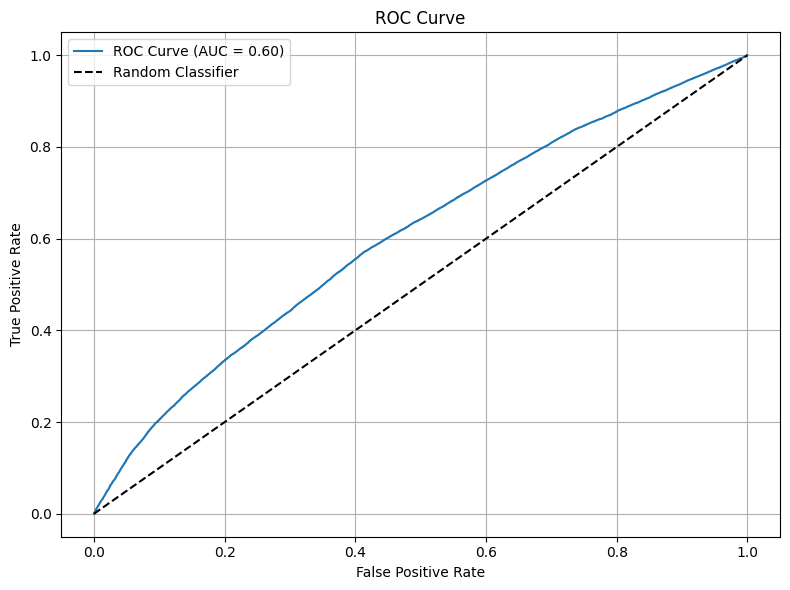

In [14]:
auc_score=roc_auc_score(y_test, y_proba)
fpr, tpr, thresholds=roc_curve(y_test, y_proba)
def roc_curve_visual(df):
    plt.figure(figsize=(8,6))
    plt.plot(fpr,tpr,label=f'ROC Curve (AUC = {auc_score :.2f})')
    plt.plot([0,1], [0,1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
roc_curve_visual(df)

- 평가 : 모델의 재현율, 정밀도, f1 score, auc 모두 매우 낮음. 모델로서 사용하기에 부적합. 튜닝이 필요하다.

### 7. 모델 튜닝

- 정밀도, 재현율 트레이드 오프 시각화

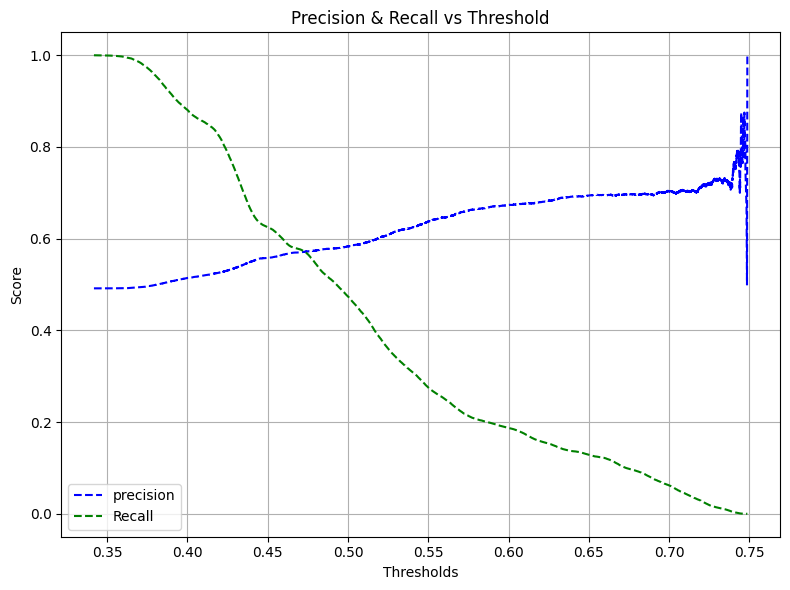

In [15]:
precisions, recalls, pr_thresholds=precision_recall_curve(y_test, y_proba)
def precision_recall(df):
    plt.figure(figsize=(8,6))
    plt.plot(pr_thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(pr_thresholds, recalls[:-1], 'g--', label='Recall')
    plt.xlabel('Thresholds')
    plt.ylabel('Score')
    plt.title('Precision & Recall vs Threshold')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
precision_recall(df)

- 이 모델은 '우울증'예측 모델이다. 즉, 우울증 환자를 잡아 내는 것에 중점을 두어야 하므로 '재현율'을 높이는 것에 중점을 둔다

1. Threshold가 0.48 보다 큰 경우 : Recall이 매우 떨어진다.
2. Threshold가 0.35 정도인 경우 : Recall은 매우 올라가지만, F1 score와 정밀도가 매우 떨어진다.
-> 따라서, 약 0.38-0.4 정도로 Threshold값을 설정한 후, 모델의 성능을 재평가 한다.

In [16]:
def custom_threshold(score):
    custom_threshold = score
    y_pred_custom = (y_proba >= custom_threshold).astype(int)

    print('confusion matrix : \n', confusion_matrix(y_test, y_pred_custom))
    print('classification report : \n', classification_report(y_test, y_pred_custom))
    print('정밀도 :',precision_score(y_test, y_pred_custom))
    print('재현율 :', recall_score(y_test, y_pred_custom))
    print('f1 score :', f1_score(y_test, y_pred_custom))
custom_threshold(0.38)

confusion matrix : 
 [[ 3024 39042]
 [ 1785 38903]]
classification report : 
               precision    recall  f1-score   support

           0       0.63      0.07      0.13     42066
           1       0.50      0.96      0.66     40688

    accuracy                           0.51     82754
   macro avg       0.56      0.51      0.39     82754
weighted avg       0.57      0.51      0.39     82754

정밀도 : 0.4991083456283277
재현율 : 0.9561295713723948
f1 score : 0.6558546104372308


- 실제 우울증 환자 중 96% 정도를 잡아낸다. 그러나, 우울증이라고 예측한 사람들 중 절반은 실제로 우울증 환자가 아니다

- 평가 : Recall은 매우 올라갔다. 그러나, 정밀도가 0.5정도로 매우 낮다.

- 모델의 문제점
1. 정확한 '우울증' 지표가 없다. 타깃 변수로 사용할 depression 변수가 존재하지 않아. 위험군으로만 분류했기 때문에, 정확한 의학적 추론이 불가능했다.
2. 필요 없는 변수 판단. depression과의 상관계수가 매우 낮은 변수들이 다수 존재했다. 이들 중 의미 없는 변수를 제거하고 추후 검증이 필요하다